In [ ]:
# Enviroment Variables
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
# ! Important ! tf.data.shuffle uses a special malloc called tcmalloc. If this malloc is not dynamicly linked it will cause a memory leak!
# LD_PRELOAD=/usr/lib/libtcmalloc_minimal.so.4

In [2]:
# Here is the imports
from tensorflow import keras
import numpy as np
import tensorflow as tf
import segmentation_models as sm
sm.set_framework('tf.keras')
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE
import random
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard
# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Global policy type is <Policy "mixed_float16">
Segmentation Models: using `tf.keras` framework.
Global policy type is <Policy "mixed_float16">


<h1>CONSTANTS</h1>

In [2]:
# Dataset Constants
DATASET_PATH = "./recordbase"
TRAIN_DIR = "train"
VAL_DIR = "val"
TEST_DIR = "test"

RECORD_ENCODING_TYPE = "ZLIB" # none if no encoding is used

# Pipeline parameters
BUFFER_SIZE = None # set buffer size to default value, change if you have bottleneck
SHUFFLE_SIZE = 256 # because dataset is too large huge shuffle sizes may cause problems with ram
BATCH_SIZE = 2 # Highly dependent on d-gpu and system ram
STEPS_PER_EPOCH = 5636//BATCH_SIZE # IMPORTANT this value should be equal to file_amount/batch_size because we can't find file_amount from tf.Dataset you should note it yourself
VAL_STEPS_PER_EPOCH = 400//BATCH_SIZE # same as steps per epoch
USE_TENSORBOARD = True
# every shard is 200 files with 36 files on last shard
# Model Constants
BACKBONE = 'efficientnetb3'
# unlabelled 0, iskemik 1, hemorajik 2
CLASSES = ['iskemik', 'kanama']
LR = 0.0001
EPOCHS = 40
MODEL_SAVE_PATH = "./models"

In [3]:
# Variables
train_dir = os.path.join(DATASET_PATH, TRAIN_DIR)
val_dir = os.path.join(DATASET_PATH, VAL_DIR)

train_filenames = tf.io.gfile.glob(f"{train_dir}/*.tfrecords")
val_filenames = tf.io.gfile.glob(f"{val_dir}/*.tfrecords")

random.shuffle(train_filenames) # shuffle tfrecord files order
random.shuffle(val_filenames)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

if USE_TENSORBOARD:
    callbacks.append(
        TensorBoard(
            log_dir="logs",
            histogram_freq=0,
            write_graph=True,
            write_images=False,
            update_freq="epoch",
        ))

# Utility functions 

In [4]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        # if whole binary image is true plt shows it as whole image is false so for bypassing this issue we assing one pixels value to 0
        image[1,1] = 0 
        plt.imshow(image)
    plt.show()

def visualize_dataset(img, mask, classes):
    kwarg = {'image': img}
    for i in range(len(classes)):
        kwarg.update({classes[i] : mask[..., i].squeeze()})
    visualize(**kwarg)

    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def plot_history(train_history):
    # Plot training & validation iou_score values
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(train_history.history['iou_score'])
    plt.plot(train_history.history['val_iou_score'])
    plt.title('Model iou_score')
    plt.ylabel('iou_score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Data Input Pipeline (Highly Optimized TFRecord Reader)

In [5]:
def parse_examples_batch(examples):
    feature_description = {
        'image/height' : tf.io.FixedLenFeature([], tf.int64),
        'image/width' : tf.io.FixedLenFeature([], tf.int64),
        'image/depth' : tf.io.FixedLenFeature([], tf.int64),
        'image/raw_image' : tf.io.FixedLenFeature([], tf.string),
        'label/raw' : tf.io.FixedLenFeature([], tf.string)
    }
    samples = tf.io.parse_example(examples, feature_description)
    return samples

def prepare_sample(features):
    image = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.float32), features["image/raw_image"])
    label = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.float64), features["label/raw"])
    return image, label

def get_dataset_optimized(filenames, batch_size, shuffle_size):
    record_dataset = tf.data.TFRecordDataset(filenames, compression_type=RECORD_ENCODING_TYPE, num_parallel_reads=AUTOTUNE)
    if shuffle_size > 0:
        record_dataset = record_dataset.shuffle(shuffle_size)
    return (record_dataset
    .repeat(EPOCHS)
    .batch(batch_size=batch_size)
    .map(map_func=parse_examples_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(map_func=prepare_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #.cache()
    .prefetch(tf.data.experimental.AUTOTUNE))

# Sanity Check Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


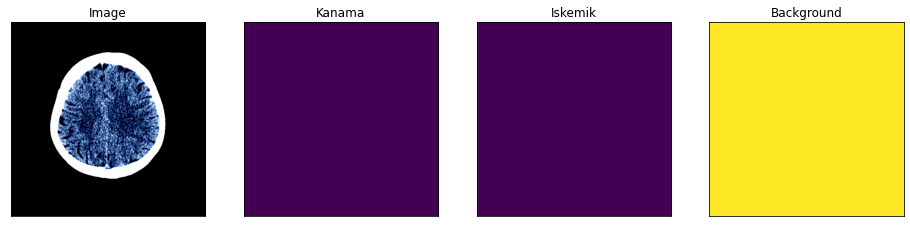

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


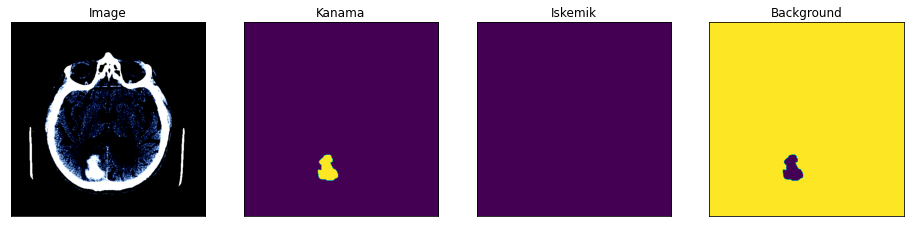

In [11]:
sanity_dataset = get_dataset_optimized(train_filenames, BATCH_SIZE, SHUFFLE_SIZE)

i = sanity_dataset.take(1)
for x in i:
    for k in range(0, 2):
        img, mask = x
        visualize_dataset(img[k].numpy(), mask[k].numpy(), ["kanama", "iskemik", "background"])

# Create Model

In [6]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# TODO redefine class weights
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

2021-08-27 17:58:52.536930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 17:58:52.547395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 17:58:52.547766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 17:58:52.548322: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

Sanity Check: Backbone Output = KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1536), dtype=tf.float32, name=None), name='top_activation/mul:0', description="created by layer 'top_activation'")
Sanity Check: VGG mod = KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1536), dtype=tf.float32, name=None), name='top_activation/mul:0', description="created by layer 'top_activation'")
Sanity Check: Decoder Output = KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 16), dtype=tf.float32, name=None), name='decoder_stage4b_relu/Relu:0', description="created by layer 'decoder_stage4b_relu'")
Sanity Check: Model Output = KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), name='softmax/Softmax:0', description="created by layer 'softmax'")


In [7]:
history = model.fit(
        get_dataset_optimized(train_filenames, BATCH_SIZE, SHUFFLE_SIZE), 
        steps_per_epoch=STEPS_PER_EPOCH, 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=get_dataset_optimized(val_filenames, BATCH_SIZE, 0), 
        validation_steps=VAL_STEPS_PER_EPOCH,
    )
# TODO make this after eval for writing accuracy in the model name
model_name = f'{history.history["val_iou_score"]}iou_{datetime.now().strftime("%H_%M_%d_%m_%Y")}'
save_path = os.path.join(MODEL_SAVE_PATH, f"{model_name}.h5")
model.save(save_path)

Epoch 1/40


2021-08-27 17:59:20.667783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-27 17:59:33.175575: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202
2021-08-27 17:59:35.854993: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-08-27 17:59:36.378916: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-08-27 17:59:36.585069: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying t

 201/2818 [=>............................] - ETA: 15:20 - loss: 0.8650 - iou_score: 0.2839 - f1-score: 0.3189

KeyboardInterrupt: 

# Train the Model

In [ ]:
def train_model(data_generators, model, callbacks):
    train_dataloader = data_generators[0]
    valid_dataloader = data_generators[1]
    # train model
    history = model.fit(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=valid_dataloader, 
        validation_steps=len(valid_dataloader),
    )
    # TODO make this after eval for writing accuracy in the model name
    save_path = os.path.join(MODEL_SAVE_PATH, f"{}acc_{}.{}")
    model.save(save_path)

# Evaluate Model

In [ ]:
def evaluate_model(eval_generator, model):
    pass

In [ ]:
model_double_unet = sm.custom.Double_Unet(backbone_name="vgg19", encoder_weights=None, input_shape=(512,512,3), classes=6)
# for the class problem solution is simple make softmax like sigmoid, if background class has the heighest probility count that pixel as 0
# if another class is higher count that as 1. think about another way to make 2nd model consider whole image. Also in the last layer
# you can add class probility


In [ ]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(
    log_dir="logs",
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    update_freq="epoch",
)

In [ ]:
model_double_unet.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_double_unet.fit(X_train, y_train, batch_size = 32, epochs = 50, callbacks=[tensorboard_callback])